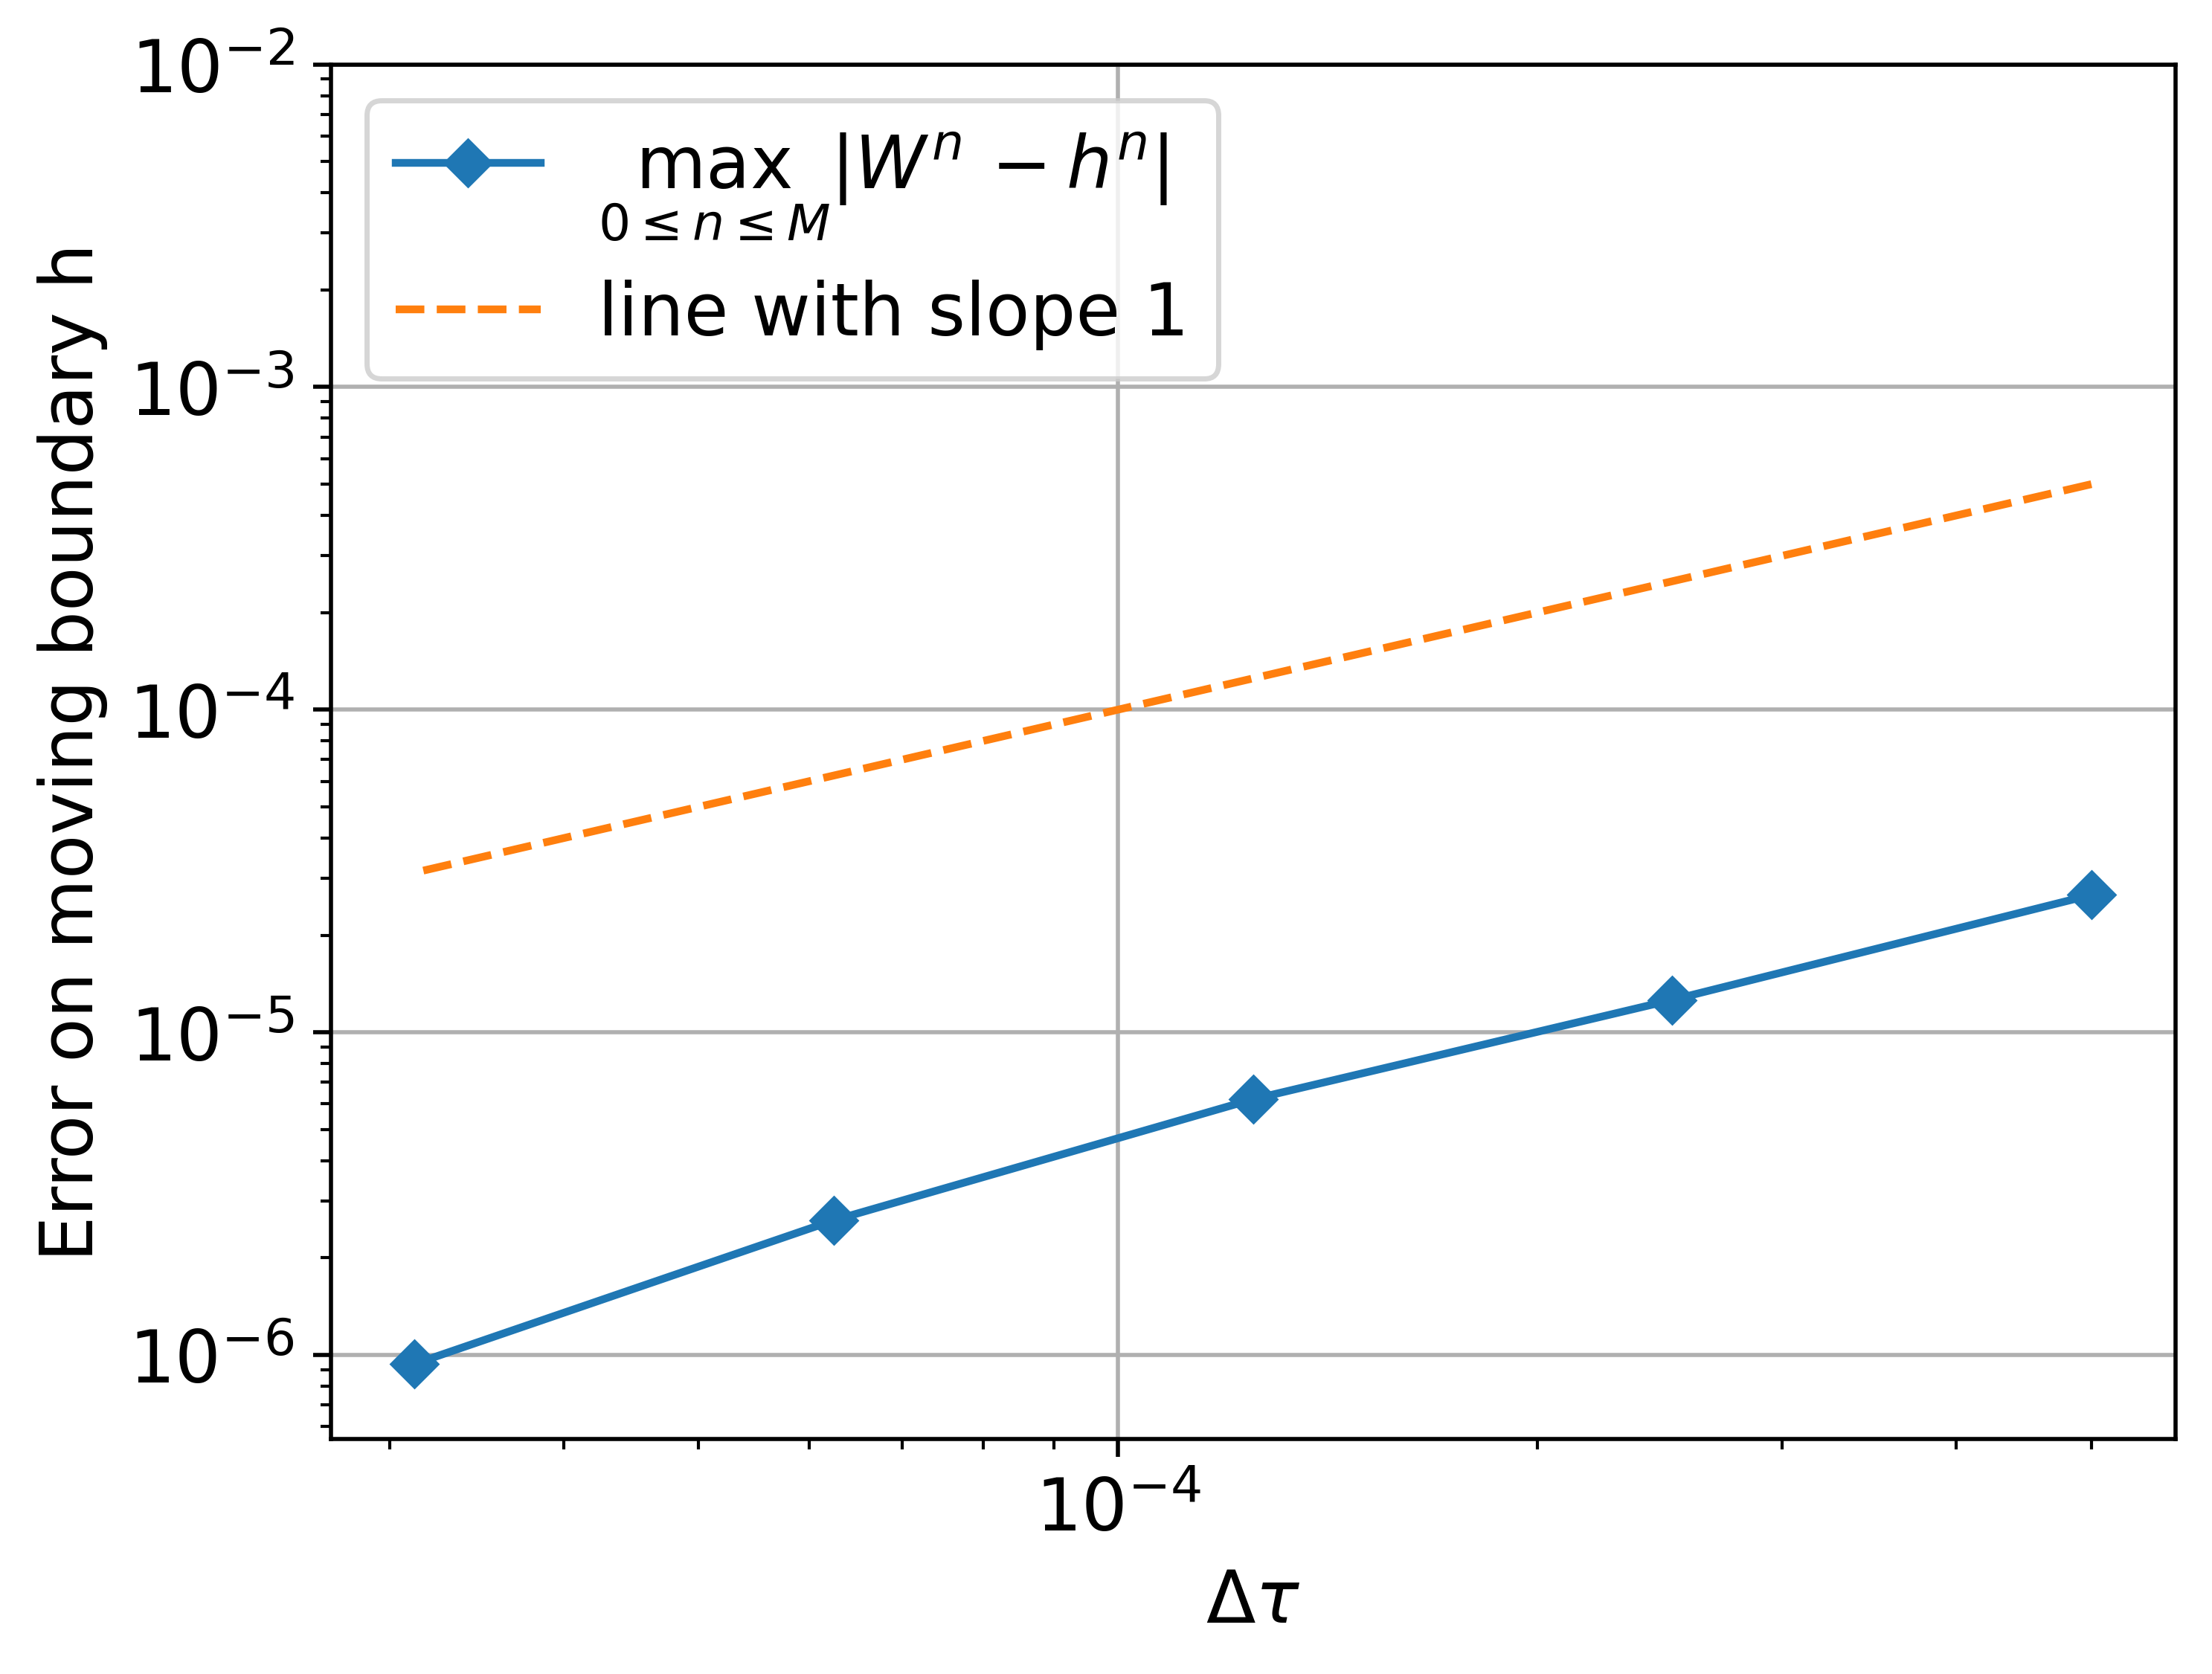

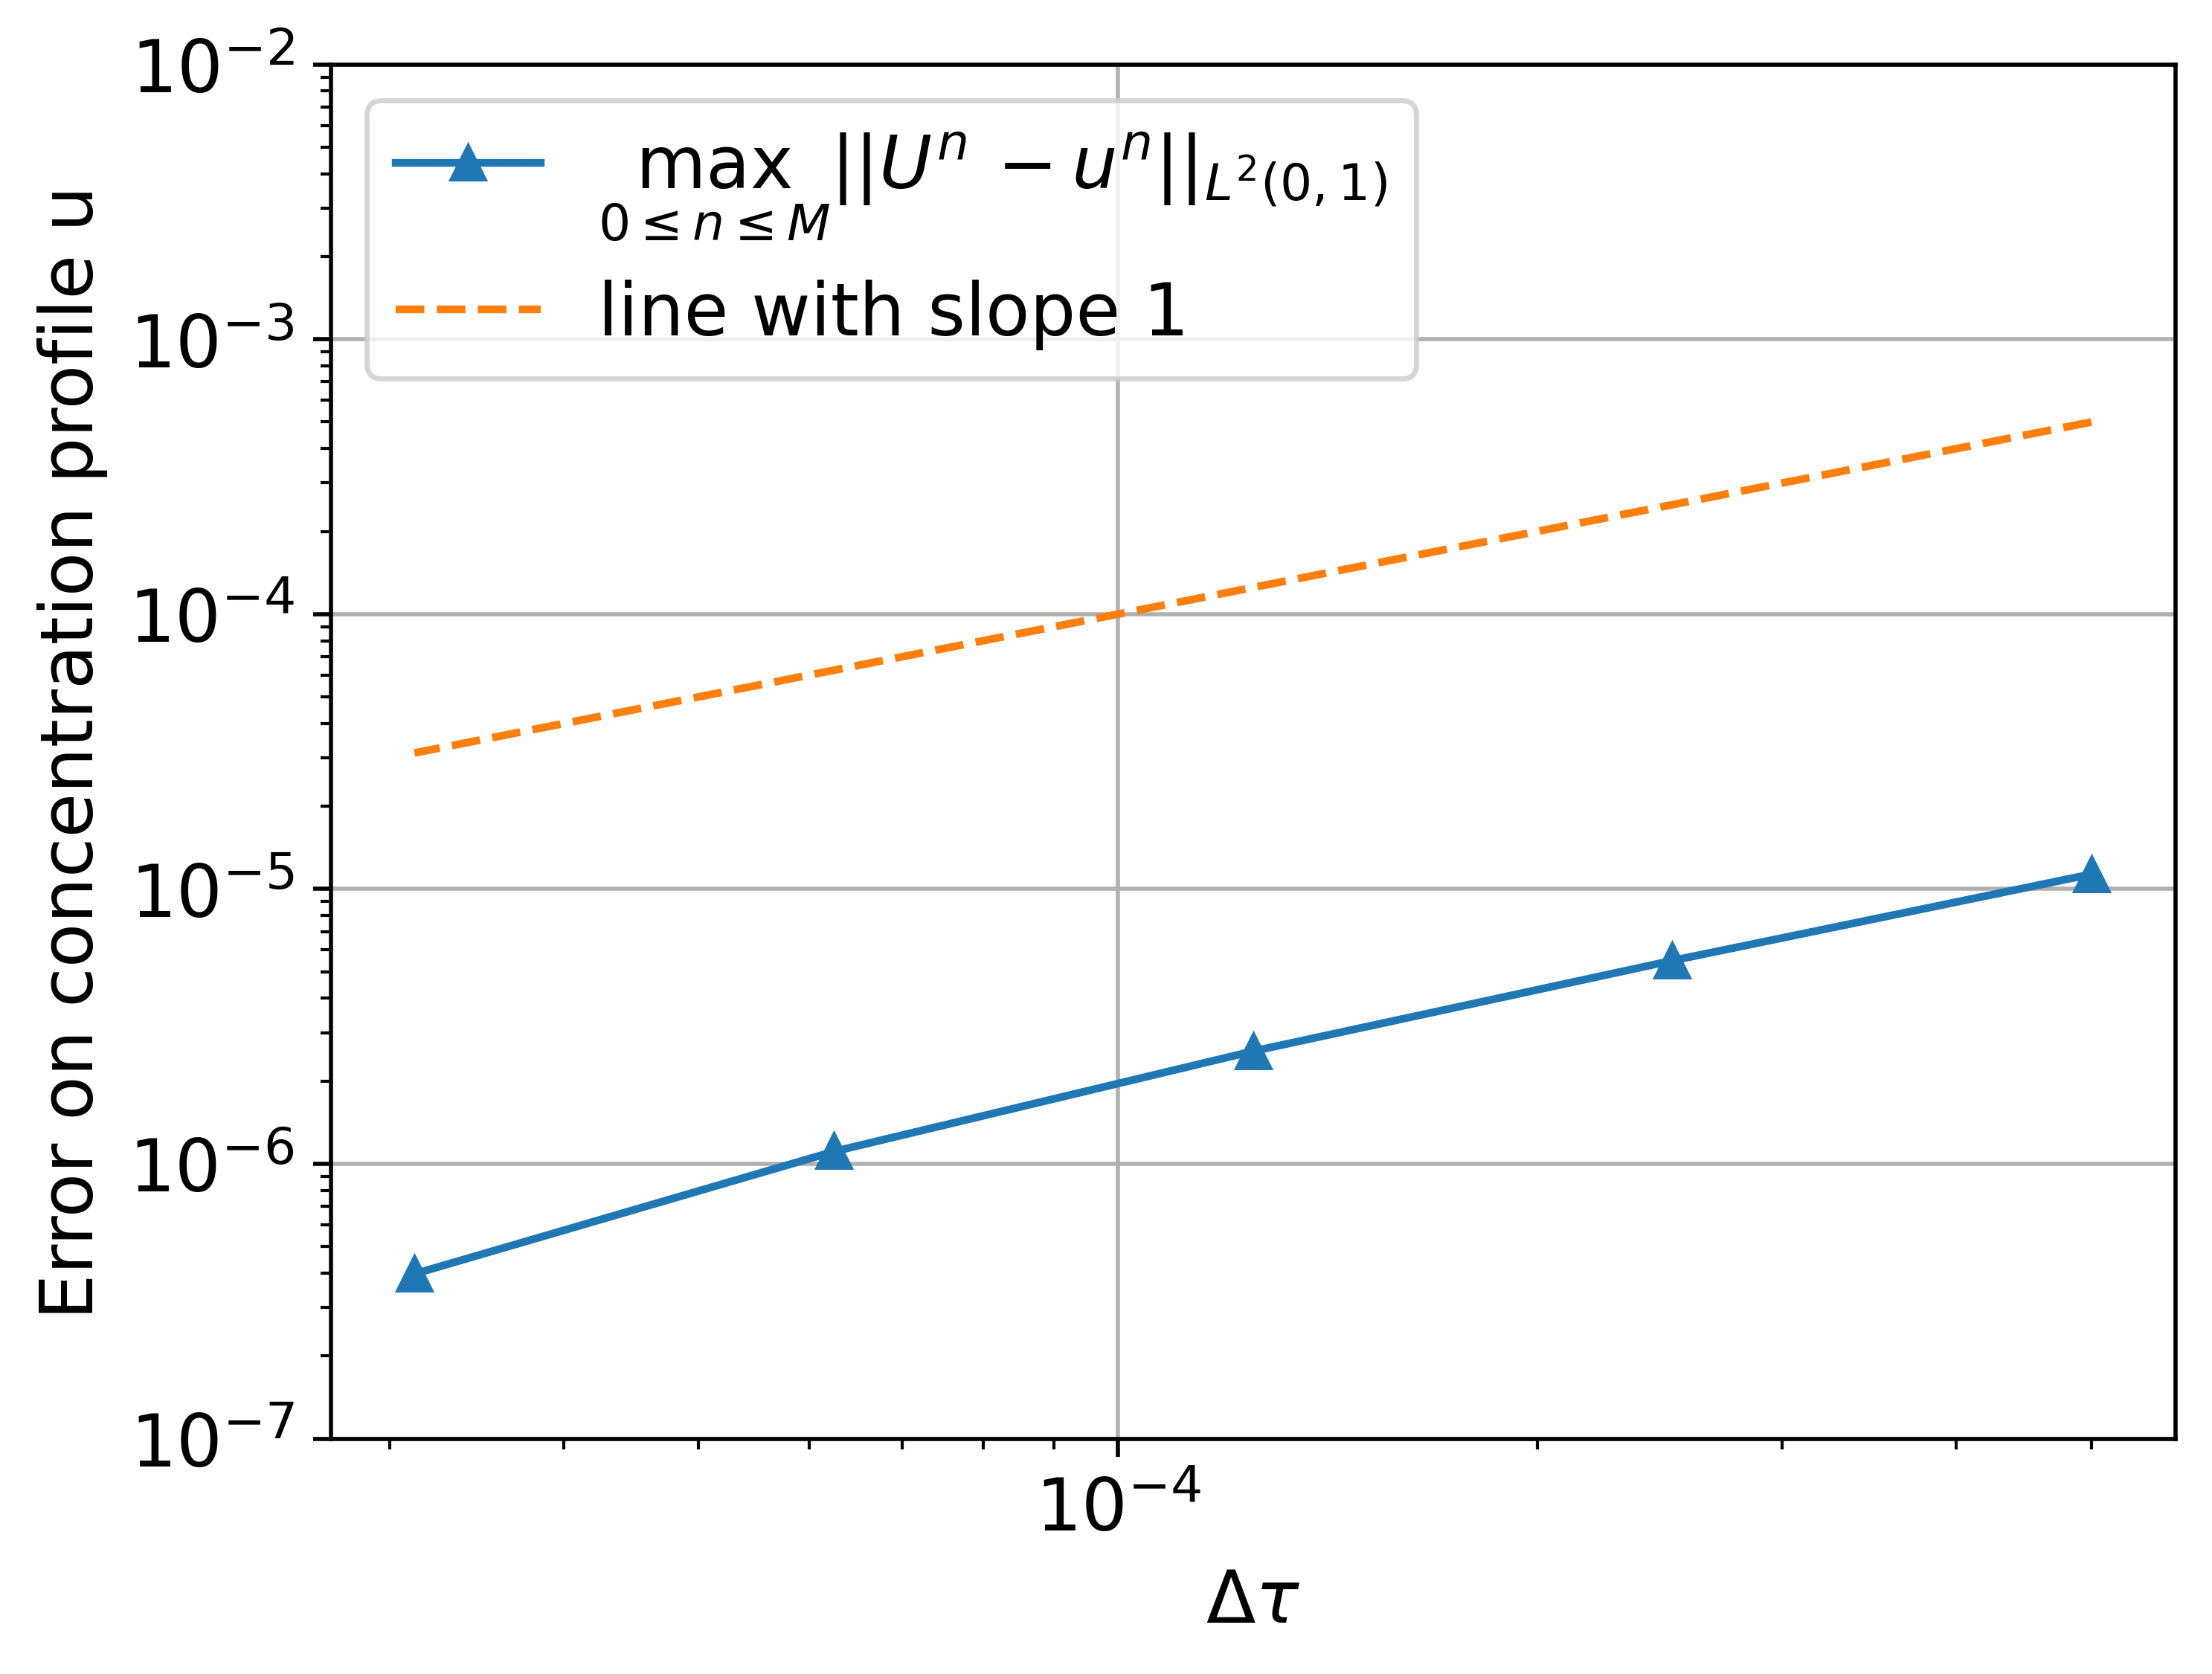

L^inf_error_mv= [[2.666862835731809e-05, 1.2601289426150686e-05, 6.202326169879591e-06, 2.614072695861225e-06, 9.380170209460914e-07]]
L^inf_error_con= [[1.132034063069397e-05, 5.486808565284233e-06, 2.5686695768807028e-06, 1.108512549981125e-06, 3.9782710392369465e-07]]
Convergence orders for moving boundary in max norm= [[1.0815722599688262, 1.022690062999362, 1.2465101346339125, 1.4786132554551723]]
Convergence orders for concentration in max norm= [[1.044878223548521, 1.0949459212641615, 1.2123962160882564, 1.4784116284006485]]


In [6]:
#### Polymer Problem for Numerical Analysis 3rd paper (fully discrete) Temporal convergence 
from numpy import * 
from pylab import *
from scipy.optimize import curve_fit
import scipy.sparse  
from scipy.sparse import diags 
from scipy.integrate import odeint 
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit # to fit the data in some curve
from itertools import cycle # need in for loop to plot with different dotted lines
D = 0.000366 # mm^2/minute
beta = 0.564 # mm/minute#
H = 2.5
a_0 = 50

####  parameter based on experimental
S_0 = 0.01
x_c = 10
####
m_0 = 0.1
m_ref = m_0

###amount of the concentration on the bottom surface of rubber paramter 
b = 1

#dimensionless number
A_0 = a_0 *m_ref* x_c/D
Bi = beta*x_c/D

#######dimensionaless penetration depth
h_0 = S_0/x_c

####time #####
T_f = 10 #final time in dimension form (minutes)
t_c = x_c**2/D ## time scale
T_s = T_f/t_c 
Tmax =T_s
deltaT = 0.001 # timestep in dimension form
del_T = [deltaT/2, deltaT/4, deltaT/8, deltaT/16, deltaT/32, deltaT/64] #deltaT/64 is the referennce one

N_mesh = [320]
s_t = [[] for i in range(len(N_mesh))] # initialize for moving bc. 
h_pri = [[] for i in range(len(N_mesh))] # initialize for velocity of moving bc.
m_c = [[] for i in range(len(N_mesh))] #initialize for concentration profile

#initialization of the order of convergence in difference norms
orders = [[0.0] * (len(del_T) - 2) for i in range(len(N_mesh))] # for moving bc
orders1 = [[0.0] * (len(del_T) - 2) for i in range(len(N_mesh))] # for the velocity of moving bc
orders2 = [[0.0] * (len(del_T) - 2) for i in range(len(N_mesh))] 
orders_con_max =  [[0.0] * (len(del_T) - 2) for i in range(len(N_mesh))] 
orders_con = [[0.0] * (len(del_T) - 2) for i in range(len(N_mesh))] #for concentration profile in L2 norm
orders_H1_con = [[0.0] * (len(del_T) - 2) for i in range(len(N_mesh))] # for concentration profile in H1 norm

#initialization of errors in difference norms
Error = [[] for i in range(len(N_mesh))]
Error1 = [[] for i in range(len(N_mesh))]
Inf_Error =[[] for i in range(len(N_mesh))]
Max_Error_con = [[] for i in range(len(N_mesh))]
Error_con = [[] for i in range(len(N_mesh))]
Error_H1_con = [[] for i in range(len(N_mesh))]

for d in range(len(del_T)): 
    T = int(T_f/del_T[d]) #total number of nodes in time step
    Time_step_nd = T_s/(T-1) # time step in dimensionless form
    Time_step_d = t_c*T_s/(T-1) # time step in dimension form
    #print('Time step in dimensionless form =', T_s/(T-1))# time step in dimensionless form
    #print('Time step in dimension form =', t_c*T_s/(T-1))# time step in dimension form
    
    ###space discretization in dimensionless for
    for N in N_mesh:
        x = linspace(0,1,N) 
        h = 1/(N-1) 
        
        ##### tridiagonal matrix for M time derivative 
        M = diags([h/6, 2*h/3, h/6], [-1, 0, 1], shape=(N, N)).toarray() 
        M[0,0] = M[0, 0]/2 
        M[N-1, N-1] =  M[N-1, N-1]/2 
        #print('M =', M) 
        Min = linalg.inv(M) 
        
        #######tridiagonal matrix for K (grad(u).grad(phi)) 
        K = diags([-1/h, 2/h, -1/h], [-1, 0, 1], shape=(N, N)).toarray() 
        K[0,0] = K[0, 0]/2 
        K[N-1, N-1] =  K[N-1, N-1]/2 
        #print(K) 
        
        ######## tridigonal matrix for mixed term  
        diagonals = zeros((3, N))   # 3 diagonals 
        diagonals[0,:] = linspace(-1, -N, N) 
        for i in range(1, N-1): 
            diagonals[1,i] = 2*h/3 - (x[i-1] + x[i+1])/2  
        diagonals[1, 0] = h/3 - x[1]/2  
        diagonals[1, N-1] = h/3 - x[N-2]/2     
        for i in range(N-1):     
            diagonals[2,i+1] = x[i+1]/2 - h/3 
        for i in range(N-1):     
            diagonals[0,i] = x[i]/2 - h/3   
        k = array([diagonals[0,0:N-1], diagonals[1], diagonals[2,1:]], dtype=object) 
        A = diags(k,[-1,0,1]).toarray() 
        E1 = N*[0] 
        E1[0] = 1
        EN = N*[0]
        EN[N-1] = 1
        Sigma_t = []
        MV_BC = []
        
        def Model(u, t): 
            #dwdt = A_0*(u[N-1]-  0.001*(1/(1+exp(-(u[N]-5))))*(1/m_ref)) 
            dwdt = A_0*(u[N-1] - 0.1/x_c*u[N]/m_ref) 
            dudt = (dwdt/u[N])*dot(dot(Min, A), u[0:N]) - (1/(u[N])**2)*dot(dot(Min, K), u[0:N]) + (1/u[N])*Bi*(b/m_ref - H*u[0])*dot(Min,E1) - (dwdt/u[N])*u[N-1]*dot(Min,EN)   
            dudt = list(dudt) 
            dudt.append(dwdt) 
            return dudt
        u0 = (N)*[m_0/m_ref] 
        u0.append(h_0) 

        #time discretization
        t = np.linspace(0, Tmax, T) 

         #solve ODE 
        z = odeint(Model, u0, t) 
        
        # to compute the error for s^prime
        #h_prime = A_0*(z[:,N-1]-  0.001*(1/(1+exp(-(z[:, N]-5))))*(1/m_ref))
        h_prime = A_0*(z[:,N-1]-  0.1/x_c*z[:, N]/m_ref) 
        h_pri[N_mesh.index(N)].append(h_prime)
        m = z[:,:-1]
        m_c[N_mesh.index(N)].append(m)
        
        #plotting u(tau, y) vs h(tau)    
        h=z[:,-1]# extracting the data of moving boundary
        s_t[N_mesh.index(N)].append(h*x_c)
        
       #plot m(t, x) vs t (dimesion domain and time)
        t_1 = t*t_c  
#computing errors and convergence orders in various norms
for k in range(len(N_mesh)):    
    for i, j in zip(range(len(del_T)-1), [int(del_T[i]/del_T[-1]) for i in range(len(del_T)-1)]):
        error = abs(s_t[k][i] - s_t[k][-1][::j])
        error2= m_c[k][i] - m_c[k][-1][::j, :]
        Error_L2_con = sqrt((1/N_mesh[k])*sum(abs(error2)**2, axis=1))
        Error_inf = max(abs(error))
        Error_max_con = max(abs(Error_L2_con))
    
        Inf_Error[k].append(Error_inf) 
        Max_Error_con[k].append(Error_max_con)
    for i in range(len(del_T)-2):
        ratio_mov_max = Inf_Error[k][i]/Inf_Error[k][i+1]
        ratio_con_max = Max_Error_con[k][i]/Max_Error_con[k][i+1]
        orders2[k][i] = math.log(ratio_mov_max, 2)
        orders_con_max[k][i] = math.log(ratio_con_max, 2)
        
    #loglog plot    
    plt.figure(dpi=500)
    plt.loglog(del_T[:-1], Inf_Error[k], "D-") 
    plt.loglog(del_T[:-1], del_T[:-1], '--')
    ax = gca()
    fontproperties = {'weight' : fontweight, 'size' : fontsize}
    for tick in ax.xaxis.get_major_ticks():
        tick.label1.set_fontsize(fontsize)
        tick.label1.set_fontweight(fontweight)
    for tick in ax.yaxis.get_major_ticks():
        tick.label1.set_fontsize(fontsize)
        tick.label1.set_fontweight(fontweight)
    plt.xlabel(r'$\Delta \tau$', fontsize= fontsize, fontweight=fontweight)
    plt.ylabel('Error on moving boundary h', fontsize= fontsize, fontweight=fontweight)
    plt.legend([r"$\max_{0\leq n\leq M}|W^n- h^n|$", r"line with slope 1"], prop=fontproperties, loc='upper left' )
    plt.ylim(0.00000055, 0.01)
    plt.grid()
    plt.show()
    #####plot for concentration loglog plot #####
    plt.figure(dpi=500)
    plt.loglog(del_T[:-1], Max_Error_con[k], '^-') 
    plt.loglog(del_T[:-1], del_T[:-1], '--')
    ax = gca()
    fontproperties = {'weight' : fontweight, 'size' : fontsize}
    for tick in ax.xaxis.get_major_ticks():
        tick.label1.set_fontsize(fontsize)
        tick.label1.set_fontweight(fontweight)
    for tick in ax.yaxis.get_major_ticks():
        tick.label1.set_fontsize(fontsize)
        tick.label1.set_fontweight(fontweight)
    plt.xlabel(r'$\Delta \tau$', fontsize= fontsize, fontweight=fontweight)
    plt.ylabel('Error on concentration profile u', fontsize= fontsize, fontweight=fontweight)
    plt.legend([r"$\max_{0\leq n \leq M }||U^n- u^n||_{L^2(0, 1)}$", r"line with slope 1"], prop=fontproperties, loc='upper left' )
    plt.ylim(0.0000001, 0.01)
    plt.grid()
    plt.show()
print('L^inf_error_mv=', Inf_Error)  
print('L^inf_error_con=', Max_Error_con) 
print("Convergence orders for moving boundary in max norm=", orders2) 
print("Convergence orders for concentration in max norm=", orders_con_max) 